In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import multiprocessing
import matplotlib.pyplot as plt

data process(Binary)

In [13]:
    def process_zip():
        #dealing with zipcode
        zip_data=pd.read_csv('ZIP.csv')
        zip_data['Zip']=zip_data['Zip'].astype(str)
        for i in range(len(zip_data['Zip'])):
            if len(zip_data['Zip'][i])==4:
                zip_data['Zip'][i]='0'+zip_data['Zip'][i]
        zip_data['Zip']=[zip_data['Zip'][i][0:3] for i in range(len(zip_data))] 
        zip_data.iloc[:,-3:]=zip_data[['Median','Mean','Pop']].apply(lambda x: x.str.replace(',',''))
        for i in range(1,4):
            zip_data.iloc[:,-i]=pd.to_numeric(zip_data.iloc[:,-i],errors='coerce')
        zip_data['weight']=zip_data['Pop']/zip_data.groupby('Zip')['Pop'].transform(sum)
        zip_data['new_mean']=zip_data['Mean']*zip_data['weight']
        zip_data['new_median']=zip_data['Median']*zip_data['weight']
        zip_new=pd.DataFrame()
        zip_new=zip_data.groupby('Zip')['new_mean','new_median'].sum()
        return zip_new
        
    def readcsv():
        LARGE_FILE = "C:\Users\Administrator\Desktop\practicum_regression\loan_data_no_current_converted.csv"
        CHUNKSIZE = 100000 # processing 100,000 rows at a time
        reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False)
        frames = []
        for df in reader:
            frames.append(df)
        loan_data = pd.concat(frames)
        return loan_data   
    def cleaning(df,zip_new,keep_desc=True,categorical_to_binary=True):
        df=df.dropna(axis=0,how='all')
        drop_list=['emp_title','title','earliest_cr_line','desc','issue_d','id','member_id','url','grade','sub_grade',
                   'int_rate','avg_cur_bal','addr_state','funded_amnt','funded_amnt_inv','collection_recovery_fee',
                   'collections_12_mths_ex_med','mths_since_last_major_derog','next_pymnt_d','recoveries','total_pymnt',
                   'total_pymnt_inv','total_rec_int','issue_d',' last_credit_pull_d','last_pymnt_d','last_credit_pull_d',
                  'total_rec_prncp','settlement_status','hardship_loan_status','hardship_status','debt_settlement_flag',
                   'verification_status','total_rec_late_fee']
        df.drop(drop_list,inplace=True,axis=1,errors='ignore')
        #deal with percentage mark
        df['revol_util']=df['revol_util'].replace('%','',regex=True).astype('float')/100
        #merge zipcode with census data
        df['zip_code']=df['zip_code'].apply(lambda x: x[:3])
        df=df.join(zip_new,on='zip_code')
        df.drop('zip_code',inplace=True,axis=1)
        #drop the observation that was missing for ALL field
        df=df.dropna(axis=0,how='all')
        #drop the features for which greater than 10% of the loans were missing data for
        num_rows=df.count(axis=0)
        df=df.iloc[:,(num_rows>=0.9*len(df)).tolist()]
        #drop the observation that was missing for any field
        df=df.dropna(axis=0,how='any')
        #label the dataset to create y
        #0:fully paid, does not meet policy:fully paid
        #1:Does not meet the credit policy. Status:Charged Off",default,charge of
        #delete grace and late
        df=df[(True^df['loan_status'].isin([4]))] 
        df=df[(True^df['loan_status'].isin([5]))]
        df=df[(True^df['loan_status'].isin([6]))] 
        #label the dataset to create y
        y=df['loan_status'].replace(1,0)
        # rename to let only 0 and 1 left
        y=y.replace(2,0)
        y=y.replace(3,1)
        y=y.replace(7,1)
        y=y.replace(8,1)
        df=df.drop(['loan_status'],axis=1) 
        return df,y

In [102]:
zipdata = process_zip()

In [103]:
df = readcsv()

In [104]:
x,y = cleaning(df,zipdata,keep_desc=False,categorical_to_binary=True)

In [101]:
from sklearn.utils import resample
# n is the number of resampled set
# this is a function with replacement
# rand_state is an int, you can change it in a for-loop to generate
# more random dataset
def resample_df(X, Y, n, rand_state):
    X_sampled, Y_sampled = resample(X, Y, random_state=rand_state, n_samples=n)
    return X_sampled, Y_sampled

we can resample the dataset to make sure that it is sufficiently random!
(I think this step is necessary, since the original dataset maybe not so random...)

In [105]:
x,y = resample(x, y, random_state=0, n_samples=len(x),replace=False)

In [106]:
len(x)

772086

In [107]:
len(y)

772086

Binary Logistic Regression(Ridge)

In [108]:
def drop_choice(df, y, n):
    if (len(df) % n != 0):
        droprows = list(np.random.choice(len(df), len(df) % n, replace=False))
        df.drop(droprows, inplace=True)
        y.drop(droprows, inplace=True)
    return df, y

drop some records in order to make sure it can be divided by n

In [109]:
x,y=drop_choice(x,y,5)

In [110]:
len(x),len(y)

(772085, 772085)

split x and y into xtrain xtest, ytrain and ytest; 
input: x, y, n:total validation fold, m: the mth fold for this trial.
The mth fold will be the test set this time, and all rest be the train set
so I concante the rest into the whole train set

In [111]:
def validation_dataset(df, y, n, m):
    interval_len=len(df)/n
    if m == 1:
        x_test = df[0:interval_len].copy()
        y_test = y[0:interval_len].copy()
        x_train = df[interval_len:len(df)].copy()
        y_train = y[interval_len:len(df)].copy()
    elif m == n:
        x_test = df[(n-1)*interval_len:len(df)].copy()
        y_test = y[(n-1)*interval_len:len(df)].copy()
        x_train = df[0:(n-1)*interval_len].copy()
        y_train = y[0:(n-1)*interval_len].copy()
    else:
        x_test = df[(m-1)*interval_len:m*interval_len].copy()
        x_train1 = df[0:(m-1)*interval_len].copy()
        x_train2 = df[m*interval_len:len(df)].copy()
        frames1 = [x_train1, x_train2]
        x_train = pd.concat(frames1)
        
        y_test = y[(m-1)*interval_len:m*interval_len].copy()
        y_train1 = y[0:(m-1)*interval_len].copy()
        y_train2 = y[m*interval_len:len(df)].copy()
        frames2 = [y_train1, y_train2]
        y_train = pd.concat(frames2)
    return x_train, x_test, y_train, y_test

In [112]:
# Find binary column method one
def bool_cols(df,isbool=True):
    bool_cols=[]
    for col in df:
        if isbool==True:
            if df[col].dropna().value_counts().index.isin([0,1]).all():
                bool_cols.append(col)
        else:
            if not df[col].dropna().value_counts().index.isin([0,1]).all():
                bool_cols.append(col)
    return bool_cols
# this above step is to facilitate normalization later
# method two
def not_bi(x):
    not_bi=[]
    for i in list(x):
        u=x[i].unique()
        if not (0 in u and 1 in u and len(u)==2): #if not binary
            not_bi.append(i)
    return not_bi
    
def reg(x_train, y_train):
           
    model = LogisticRegression(penalty='l2',class_weight='balanced',solver='sag',n_jobs=-1)
    
    model = model.fit(x_train, y_train)
        
    return model
    
def ModelValuation(x_test,y_test,model):
        
    probs = model.predict_proba(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
    plt.figure(1)
    plt.plot(fpr, tpr, label='LogisticRegression')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
        
    print("Area Under the Curve (AUC) from prediction score is %f" % metrics.roc_auc_score(y_test, probs[:, 1]))
    
    return None  
    
def y_pred(x_test,threshold=0.5):
        
    if threshold == 0.5:
        y_predicted = model.predict(x_test)
    else:
        probs = model.predict_proba(x_test)
        y_predicted = np.array(probs[:,1] >= threshold).astype(int)
        
    return y_predicted    
    
def GetScores(y_test,y_predicted):
    #G means score 
    CM = metrics.confusion_matrix(y_test, y_predicted)
    TN = CM[0,0]
    FN = CM[1,0]
    TP = CM[1,1]
    FP = CM[0,1]
        
    sensitivity = float(TP)/float(TP+FN)
    specificity = float(TN)/float(TN+FP)
    G = np.sqrt(sensitivity*specificity)
    print("G score is %f" % G)
    print("Specificity is %f" % specificity)
        
    # Generate and display different evaluation metrics
    print("Mean accuracy score is %f" % metrics.accuracy_score(y_test, y_predicted))
          
    print("Confusion Marix")
    print(CM)
        
    return specificity , G
        
# Convenience function to plot confusion matrix
def confusion(y_test,y_predicted,title):
        
    # Define names for the three Iris types
    names = ['Default', 'Not Default']
    
    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(y_test, y_predicted, bins=2)
    
    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
        
    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title(title)
        
    return None
            
def find_threshold(x_test,y_test):
    
    probs = model.predict_proba(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
    sensitivity = tpr
    specificity = 1 - fpr
    G = np.sqrt(sensitivity*specificity)
        
    plt.figure(2)
    plt.plot(thresholds,G)
    plt.xlabel('Thresholds')
    plt.ylabel('G-Scores')
    plt.title('G-Scores with different thresholds')
    plt.show()
        
        
    print("The highest G score is %f with threshold at %f" % (np.amax(G),thresholds[np.argmax(G)]) )
        
    return thresholds[np.argmax(G)]
    # this is just testing, we add weight so we don't need to adjust threshold

### Trial 1

In [113]:
not_bi = not_bi(x)

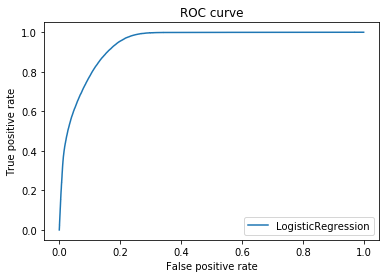

Area Under the Curve (AUC) from prediction score is 0.942603
G score is 0.873891
Specificity is 0.798804
Mean accuracy score is 0.831877
Confusion Marix
[[97403 24533]
 [ 1428 31053]]


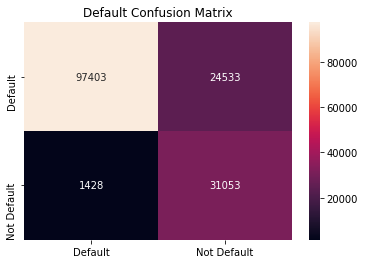

In [114]:
# Split
#The only difference is the train_test split is substituted by this function every time
# the evaluation function also works each time
x_train, x_test, y_train, y_test = validation_dataset(x,y,5,1)
# Normalize

scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled=x_train
x_test_scaled=x_test

x_train_scaled[not_bi] = scaler.transform(x_train[not_bi])
x_test_scaled[not_bi]  = scaler.transform(x_test[not_bi])

# Fit model
model = reg(x_train_scaled,y_train)
# Evaluate model
ModelValuation(x_test_scaled,y_test,model)
y_predicted = y_pred(x_test_scaled,threshold=0.5)
spec , G = GetScores(y_test,y_predicted)
confusion(y_test,y_predicted,'Default Confusion Matrix')

### Trial 2

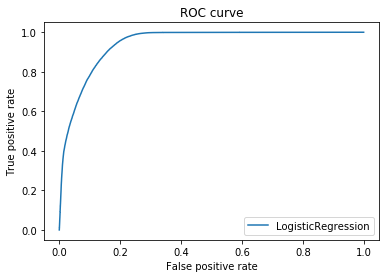

Area Under the Curve (AUC) from prediction score is 0.942971
G score is 0.875067
Specificity is 0.799449
Mean accuracy score is 0.832680
Confusion Marix
[[97548 24471]
 [ 1366 31032]]


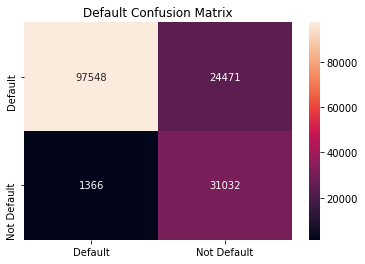

In [116]:
# Split
x_train, x_test, y_train, y_test = validation_dataset(x,y,5,2)
# Normalize

scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled=x_train
x_test_scaled=x_test

x_train_scaled[not_bi] = scaler.transform(x_train[not_bi])
x_test_scaled[not_bi]  = scaler.transform(x_test[not_bi])

# Fit model
model = reg(x_train_scaled,y_train)
# Evaluate model
ModelValuation(x_test_scaled,y_test,model)
y_predicted = y_pred(x_test_scaled,threshold=0.5)
spec , G = GetScores(y_test,y_predicted)
confusion(y_test,y_predicted,'Default Confusion Matrix')

### Trial 3

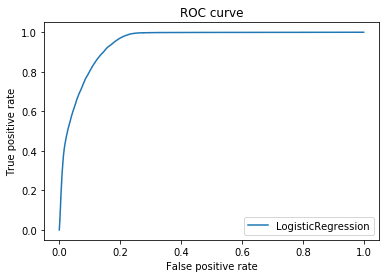

Area Under the Curve (AUC) from prediction score is 0.946674
G score is 0.881556
Specificity is 0.803068
Mean accuracy score is 0.838075
Confusion Marix
[[97641 23944]
 [ 1060 31772]]


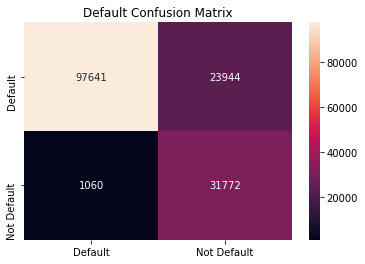

In [117]:
# Split
x_train, x_test, y_train, y_test = validation_dataset(x,y,5,3)
# Normalize

scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled=x_train
x_test_scaled=x_test

x_train_scaled[not_bi] = scaler.transform(x_train[not_bi])
x_test_scaled[not_bi]  = scaler.transform(x_test[not_bi])

# Fit model
model = reg(x_train_scaled,y_train)
# Evaluate model
ModelValuation(x_test_scaled,y_test,model)
y_predicted = y_pred(x_test_scaled,threshold=0.5)
spec , G = GetScores(y_test,y_predicted)
confusion(y_test,y_predicted,'Default Confusion Matrix')

Trial 4

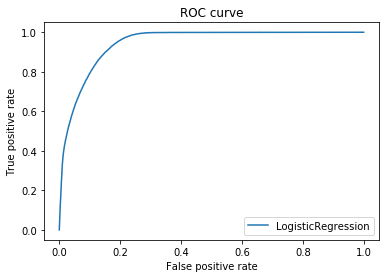

Area Under the Curve (AUC) from prediction score is 0.944988
G score is 0.876204
Specificity is 0.800872
Mean accuracy score is 0.833956
Confusion Marix
[[97732 24300]
 [ 1340 31045]]


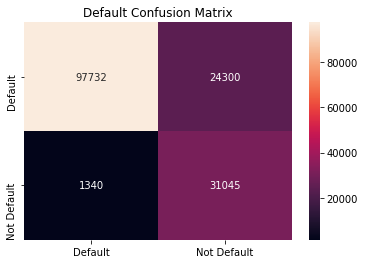

In [118]:
# Split
x_train, x_test, y_train, y_test = validation_dataset(x,y,5,4)
# Normalize

scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled=x_train
x_test_scaled=x_test

x_train_scaled[not_bi] = scaler.transform(x_train[not_bi])
x_test_scaled[not_bi]  = scaler.transform(x_test[not_bi])

# Fit model
model = reg(x_train_scaled,y_train)
# Evaluate model
ModelValuation(x_test_scaled,y_test,model)
y_predicted = y_pred(x_test_scaled,threshold=0.5)
spec , G = GetScores(y_test,y_predicted)
confusion(y_test,y_predicted,'Default Confusion Matrix')

Trial 5

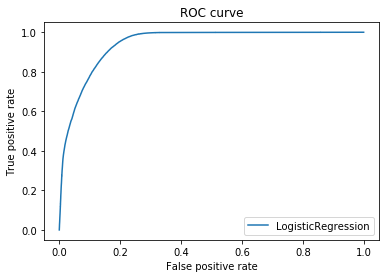

Area Under the Curve (AUC) from prediction score is 0.942249
G score is 0.873416
Specificity is 0.797676
Mean accuracy score is 0.831314
Confusion Marix
[[97062 24619]
 [ 1429 31307]]


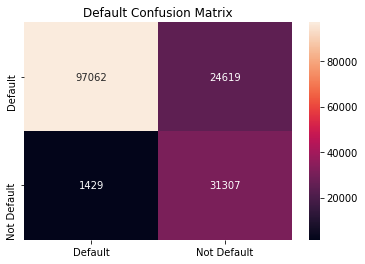

In [119]:
# Split
x_train, x_test, y_train, y_test = validation_dataset(x,y,5,5)
# Normalize

scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled=x_train
x_test_scaled=x_test

x_train_scaled[not_bi] = scaler.transform(x_train[not_bi])
x_test_scaled[not_bi]  = scaler.transform(x_test[not_bi])

# Fit model
model = reg(x_train_scaled,y_train)
# Evaluate model
ModelValuation(x_test_scaled,y_test,model)
y_predicted = y_pred(x_test_scaled,threshold=0.5)
spec , G = GetScores(y_test,y_predicted)
confusion(y_test,y_predicted,'Default Confusion Matrix')

Conclusion: from all these trials, we can see that the AUC is around 0.94, mean accuracy is around 0.83, they are quite stable with only a slight volitility, as well as the G score and specifity. So we can conclude that this model is stable.